In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from collections import Counter
from textblob import TextBlob
import gensim.downloader as api
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
!pip install unidecode

# **Data** **Preprocessing**

In [ ]:
angry_df = pd.read_csv('/content/angriness.csv')
happy_df = pd.read_csv('/content/happiness.csv')
sad_df = pd.read_csv('/content/sadness.csv')

In [ ]:
# Explore each dataset
print(angry_df.info())
print(angry_df.describe())
print(angry_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    696 non-null    object
 1   intensity  696 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB
None
                                                  content  intensity
count                                                 696        696
unique                                                498          1
top     ['Hating Me Won’T Make You Pretty.', 'Anger Is...  angriness
freq                                                  100        696
                                             content  intensity
0  Sometimes I’m not angry, I’m hurt and there’s ...  angriness
1                     Not available for busy people☺  angriness
2  I do not exist to impress the world. I exist t...  angriness
3  Everything is getting expensive except some pe...  angriness
4       My phone screen is br

In [ ]:
print(happy_df.info())
print(happy_df.describe())
print(happy_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    708 non-null    object
 1   intensity  708 non-null    object
dtypes: object(2)
memory usage: 11.2+ KB
None
                                                  content  intensity
count                                                 708        708
unique                                                704          1
top     Its nice when someone cares about you as much ...  happiness
freq                                                    2        708
                                             content  intensity
0  Wants to know how the hell I can remember word...  happiness
1  Love is a long sweet dream & marriage is an al...  happiness
2  The world could be amazing when you are slight...  happiness
3  My secret talent is getting tired without doin...  happiness
4  Khatarnaak Whatsapp Status

In [ ]:
print(sad_df.info())
print(sad_df.describe())
print(sad_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    635 non-null    object
 1   intensity  635 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB
None
                                                  content intensity
count                                                 635       635
unique                                                390         1
top     ['You Hurt Me But I Still Love You.', 'True Lo...   sadness
freq                                                  134       635
                                             content intensity
0  Never hurt people who love you a lot, because ...   sadness
1  Don’t expect me to tell you what you did wrong...   sadness
2  I preferred walking away than fighting for you...   sadness
3  Moving forward in life isn’t the hard part, it...   sadness
4  Never cry for anyone in your life, b

In [ ]:
# Check for missing values
print(angry_df.isnull().sum())
print(happy_df.isnull().sum())
print(sad_df.isnull().sum())

content      0
intensity    0
dtype: int64
content      0
intensity    0
dtype: int64
content      0
intensity    0
dtype: int64


In [ ]:
def preprocess_text(text):
    # Step 1: Text Decoding
    text = unidecode(text)

    # Step 2: Lowercasing
    text = text.lower()

    # Step 3: Removing special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 4: Tokenization
    tokens = word_tokenize(text)

    # Step 5: Stopword Removal
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Step 6: Lemmatization/Stemming
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Use stemming if required

    # Step 7: Join tokens back to a single string
    return ' '.join(tokens)

# Applying preprocessing to each dataset
angry_df['cleaned_text'] = angry_df['content'].apply(preprocess_text)
happy_df['cleaned_text'] = happy_df['content'].apply(preprocess_text)
sad_df['cleaned_text'] = sad_df['content'].apply(preprocess_text)


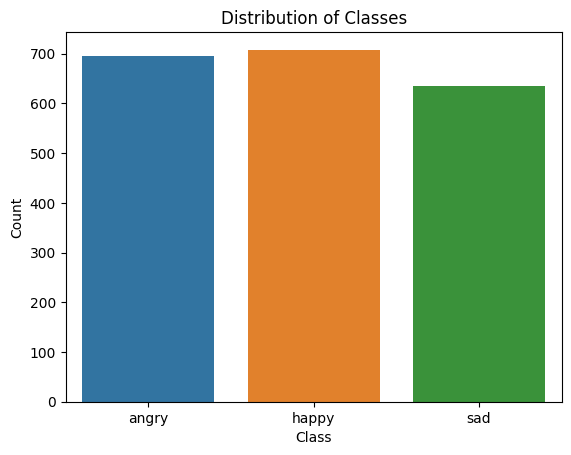

In [ ]:
# Count the number of samples in each dataset
angry_df['label'] = 'angry'
happy_df['label'] = 'happy'
sad_df['label'] = 'sad'

sns.countplot(x='label', data=pd.concat([angry_df, happy_df, sad_df]),hue='label')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

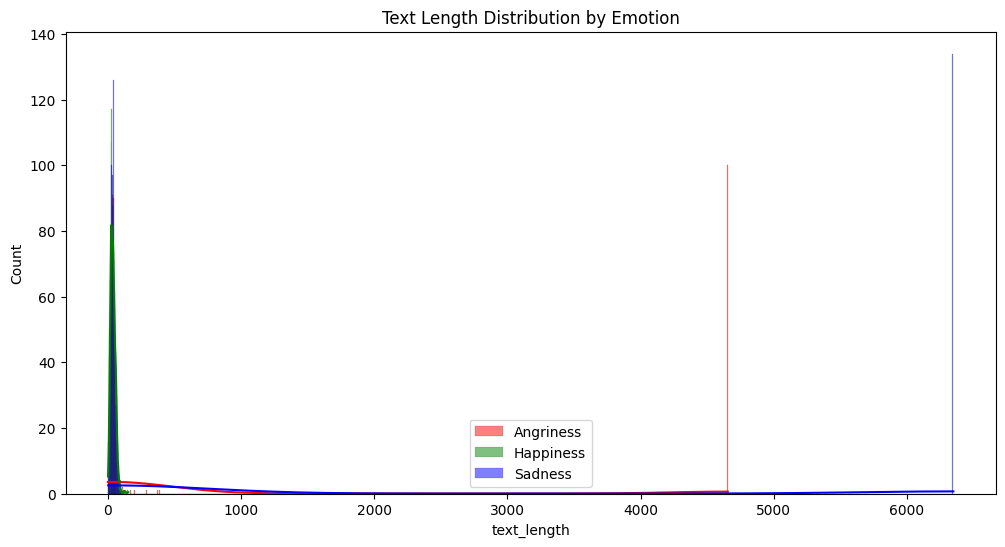

In [ ]:
# Text length distribution
angry_df['text_length'] = angry_df['cleaned_text'].apply(len)
happy_df['text_length'] = happy_df['cleaned_text'].apply(len)
sad_df['text_length'] = sad_df['cleaned_text'].apply(len)

# Plotting text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(angry_df['text_length'], kde=True, label='Angriness', color='red')
sns.histplot(happy_df['text_length'], kde=True, label='Happiness', color='green')
sns.histplot(sad_df['text_length'], kde=True, label='Sadness', color='blue')
plt.legend()
plt.title('Text Length Distribution by Emotion')
plt.show()


In [ ]:
# Combining the datasets into a single DataFrame
combined_df = pd.concat([angry_df, happy_df, sad_df], ignore_index=True)

In [ ]:
# Extracting features and labels
X = combined_df['cleaned_text']
y = combined_df['label']

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
# Displaying some of the preprocessed data
print("Training data size:", X_train.shape)
print("Test data size:", X_test.shape)

Training data size: (1631, 2151)
Test data size: (408, 2151)


# **Feature Engineering**

In [ ]:
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = Counter(tag for word, tag in pos_tags)
    return pos_counts

# Apply POS tagging and extract features
combined_df['pos_tags'] = combined_df['cleaned_text'].apply(pos_tagging)

# Convert POS tag counts to features
pos_df = pd.DataFrame(list(combined_df['pos_tags']))
pos_df = pos_df.fillna(0)

print("POS tagging feature matrix shape:", pos_df.shape)

POS tagging feature matrix shape: (2039, 29)


In [ ]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    return sentiment_polarity, sentiment_subjectivity

# Extract sentiment features
combined_df['polarity'], combined_df['subjectivity'] = zip(*combined_df['cleaned_text'].apply(get_sentiment))

print("Sentiment feature example:")
print(combined_df[['polarity', 'subjectivity']].head())

Sentiment feature example:
   polarity  subjectivity
0 -0.250000         0.550
1  0.250000         0.350
2  0.468182         0.750
3 -0.500000         0.700
4  0.000000         0.125


In [ ]:
#wv = api.load('word2vec-google-news-300')

In [ ]:
wv = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# Since you've loaded 'glove-wiki-gigaword-50', update k to 50
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=50):
    if len(tokens_list) < 1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    return np.mean(vectorized, axis=0)

combined_df['cleaned_tokens'] = combined_df['cleaned_text'].apply(word_tokenize)
combined_df['word2vec'] = combined_df['cleaned_tokens'].apply(lambda x: get_average_word2vec(x, wv))

print("Word2Vec feature example:")
print(combined_df['word2vec'].head())

Word2Vec feature example:
0    [-0.007876996, -0.11141659, 0.12711, -0.30275,...
1    [0.72399, -0.013186674, 0.33347, -0.30585, 0.1...
2    [0.33350956, 0.32108513, -0.22690246, -0.09532...
3    [0.305774, -0.30088857, 0.28707203, -0.4602334...
4    [0.45101798, 0.38608676, 0.81366, 0.19924626, ...
Name: word2vec, dtype: object


In [ ]:
from scipy.sparse import csr_matrix, hstack

# Converting dense features to sparse matrices
pos_features = csr_matrix(pos_df.values)
sentiment_features = csr_matrix(combined_df[['polarity', 'subjectivity']].values)
word2vec_features = csr_matrix(np.array(combined_df['word2vec'].tolist()))

# Combine all features
combined_features = hstack([X_vectorized, pos_features, sentiment_features, word2vec_features])

print("Combined feature matrix shape:", combined_features.shape)


Combined feature matrix shape: (2039, 2232)


## **Model Fitting**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Initialize the SVC model
svc_model = SVC(random_state=42)

In [ ]:
# Train the model
svc_model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
# Make predictions
y_pred = svc_model.predict(X_test)

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.821078431372549
Classification Report:
               precision    recall  f1-score   support

       angry       0.87      0.83      0.85       139
       happy       0.74      0.89      0.81       142
         sad       0.89      0.72      0.80       127

    accuracy                           0.82       408
   macro avg       0.83      0.82      0.82       408
weighted avg       0.83      0.82      0.82       408

Confusion Matrix:
 [[116  21   2]
 [  6 127   9]
 [ 11  24  92]]


## **Hyperparameter Tuning for SVC**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [ ]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.7719254798221422


In [ ]:
# Retrain SVC with best parameters
best_svc_model = grid_search.best_estimator_
y_pred_best = best_svc_model.predict(X_test)

In [ ]:
# Final evaluation
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Final Classification Report:\n", classification_report(y_test, y_pred_best))
print("Final Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Final Model Accuracy: 0.7549019607843137
Final Classification Report:
               precision    recall  f1-score   support

       angry       0.77      0.83      0.80       139
       happy       0.75      0.69      0.72       142
         sad       0.74      0.75      0.74       127

    accuracy                           0.75       408
   macro avg       0.75      0.76      0.75       408
weighted avg       0.75      0.75      0.75       408

Final Confusion Matrix:
 [[115  13  11]
 [ 21  98  23]
 [ 13  19  95]]


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validate the best model
cv_scores = cross_val_score(best_svc_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-validation Scores: [0.76146789 0.79447853 0.79141104 0.75460123 0.75766871]
Mean CV Accuracy: 0.7719254798221422


SVC model accuray is 83%
where as the accuray after hyperparameter has dropped to 77%
so the SVC model is finalized

# **Model Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:

# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Final Model Accuracy:", accuracy)

    print("Final Classification Report:\n", classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Final Confusion Matrix:\n", conf_matrix)

    return accuracy, conf_matrix



In [ ]:
# Cross-validate the model
def cross_validate_model(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-validation Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))
    return cv_scores



In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:

# Evaluate the model
accuracy, conf_matrix = evaluate_model(svc_model, X_test, y_test)

Final Model Accuracy: 0.821078431372549
Final Classification Report:
               precision    recall  f1-score   support

       angry       0.87      0.83      0.85       139
       happy       0.74      0.89      0.81       142
         sad       0.89      0.72      0.80       127

    accuracy                           0.82       408
   macro avg       0.83      0.82      0.82       408
weighted avg       0.83      0.82      0.82       408

Final Confusion Matrix:
 [[116  21   2]
 [  6 127   9]
 [ 11  24  92]]
Cross-validation Scores: [0.74617737 0.80368098 0.75766871 0.75766871 0.74846626]
Mean CV Accuracy: 0.7627324065214536


In [ ]:

# Cross-validate the model
cv_scores = cross_validate_model(svc_model, X_train, y_train)

Cross-validation Scores: [0.74617737 0.80368098 0.75766871 0.75766871 0.74846626]
Mean CV Accuracy: 0.7627324065214536


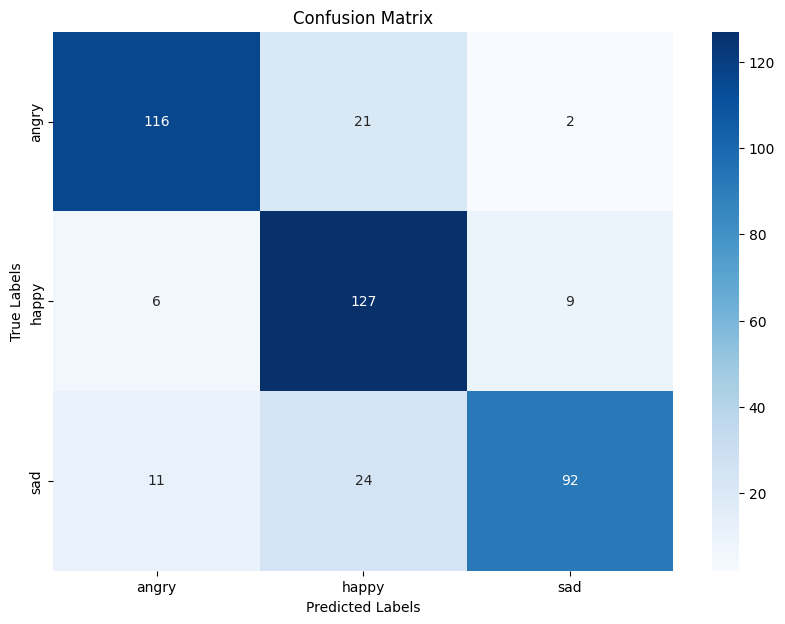

In [ ]:
# Plot confusion matrix
class_labels = ['angry', 'happy', 'sad']
plot_confusion_matrix(conf_matrix, class_labels)